In [1]:
import pickle
import numpy as np
import sklearn.decomposition as dc
import matplotlib.pyplot as plt

from scipy.signal import detrend

# Preprocess Data

In [2]:
def preprocess_data(x, if_smooth=True, if_detrend=True, smooth_window=20):
    """A function to preprocess data using smoothing and/or detrending.

    Args:
        x (numpy.ndarray): IR spectra (n_sample, n_feature)
        if_smooth (bool, optional): if perform smoothing. Defaults to True.
        if_detrend (bool, optional): if perform detrending. Defaults to True.
        smooth_window (int, optional): the rolling average window for smoothing

    Returns:
        numpy.ndarray: preprocessed spectra
    """
    out = []
    for x_ in x:
        if if_smooth:
            x_ = np.convolve(x_, np.ones(smooth_window) / smooth_window, mode='valid')
        if if_detrend:
            x_ = detrend(x_)
        out.append(x_)
    out = np.array(out)
    return out

## Smooth Only

In [3]:
%%time
files = ['train', 'unseen'] # raw data

for file in files:
    for window in [5, 10, 15, 20, 25, 30, 35, 40]:
        with open(f'./data/{file}.pickle', 'rb') as handle:
            x = pickle.load(handle)
            y = pickle.load(handle)

        x = preprocess_data(x, if_smooth=True, if_detrend=False, smooth_window=window)

        with open(f'./data/smooth_{file}_window_{window}.pickle', 'wb') as handle:
            pickle.dump(x, handle)
            pickle.dump(y, handle)

CPU times: user 1.09 s, sys: 404 ms, total: 1.5 s
Wall time: 15.5 s


## Detrend Only

In [8]:
%%time
files = ['train', 'unseen'] # raw data

for file in files:
    with open(f'./data/{file}.pickle', 'rb') as handle:
        x = pickle.load(handle)
        y = pickle.load(handle)
    
    x = preprocess_data(x, if_smooth=False, if_detrend=True)
    
    with open(f'./data/detrend_{file}.pickle', 'wb') as handle:
        pickle.dump(x, handle)
        pickle.dump(y, handle)

CPU times: user 1.06 s, sys: 53 ms, total: 1.11 s
Wall time: 3.42 s


## Smooth and Detrend

In [4]:
%%time
files = ['train', 'unseen'] # raw data

for file in files:
    for window in [5, 10, 15, 20, 25, 30, 35, 40]:
        with open(f'./data/{file}.pickle', 'rb') as handle:
            x = pickle.load(handle)
            y = pickle.load(handle)

        x = preprocess_data(x, if_smooth=True, if_detrend=True, smooth_window=window)

        with open(f'./data/both_{file}_window_{window}.pickle', 'wb') as handle:
            pickle.dump(x, handle)
            pickle.dump(y, handle)

CPU times: user 8.66 s, sys: 391 ms, total: 9.05 s
Wall time: 22.6 s


# Data Visualization

In [4]:
from helping import rcparams, format_axis
rcparams(1)

## Load All Data

In [24]:
DATA_DIR = '/Users/sjiang87/data_weight/plastic_rotating/data/'
# raw
with open(DATA_DIR + 'train.pickle', 'rb') as handle:
    x1 = pickle.load(handle)
    y = pickle.load(handle)
with open(DATA_DIR + 'unseen.pickle', 'rb') as handle:
    x1u = pickle.load(handle)
    yu = pickle.load(handle).astype('object')
# smooth
with open(DATA_DIR + 'smooth_train.pickle', 'rb') as handle:
    x2 = pickle.load(handle)
with open(DATA_DIR + 'smooth_unseen.pickle', 'rb') as handle:
    x2u = pickle.load(handle) 
# detrend
with open(DATA_DIR + 'detrend_train.pickle', 'rb') as handle:
    x3 = pickle.load(handle)
with open(DATA_DIR + 'detrend_unseen.pickle', 'rb') as handle:
    x3u = pickle.load(handle)
# both
with open(DATA_DIR + 'both_train.pickle', 'rb') as handle:
    x4 = pickle.load(handle)
with open(DATA_DIR + 'both_unseen.pickle', 'rb') as handle:
    x4u = pickle.load(handle)
yu[yu == 'BKPS'] = 'BK/PS'
yu[yu == 'BKPVC'] = 'BK/PVC'
yu[yu == 'PSPP'] = 'PS/PP'
yu[yu == 'PVCPE'] = 'PE/PVC'
yu[yu == 'BKPVCPPPS'] = 'BK/PVC/PS/PP'
np.unique(yu)

array(['BK/PS', 'BK/PVC', 'BK/PVC/PS/PP', 'PE/PVC', 'PS/PP'], dtype=object)

## Plot Spectra

In [14]:
def plot_spectra(x1, x2, x3, x4, y, plastic='PE', if_save=False):
    """A function to plot raw and preprocessed spectra.

    Args:
        x1 (numpy.ndarray): raw spectra
        x2 (numpy.ndarray): smoothed spectra
        x3 (numpy.ndarray): detrended spectra
        x4 (numpy.ndarray): smoothed and detrended spectra
        y (numpy.ndarray): plastic type
        plastic (str, optional): plastic name. Defaults to 'PE'.
        if_save (bool, optional): if save figure. Defaults to False.
    """

    idx = np.where(y == plastic)[0] # index of spectra belonging to a certain plastic
    x = [x1[idx], x2[idx], x3[idx], x4[idx]] # spectra belonging to a certain plastic

    n = x1.shape[-1] # spectra size (i.e., 975)
    wavelength = np.linspace(2.8583, 5.0043, n) # um
    wavenumber = 1 / wavelength * 10000 # cm-1

    labels = ['(a)', '(b)', '(c)', '(d)']

    fig, ax = plt.subplots(figsize=(12, 8), ncols=2, nrows=2)
    ax = ax.ravel()
    for i, x_ in enumerate(x):
        x_ = x_[:10] # first ten spectra

        # normalize between 0 and 1
        x_ = x_ - x_.min(axis=1)[..., None]
        x_ = x_ / x_.max(axis=1)[..., None]
        x_ = x_.T
        
        ax[i].plot(wavenumber[:len(x_)], x_)
        ax[i].set_xlim([2000, 3500])
        ax[i].set_ylim([0, 1])
        ax[i].set_xlabel('Wavenumber (cm$^{-1}$)', fontsize=20);
        ax[i].set_ylabel('Normalized Intensity', fontsize=20)
        ax[i].text(1650, 1, labels[i], fontsize=25)
        format_axis(ax[i])
    plt.tight_layout()
    if if_save:
        plt.savefig(f'../figure/spectra_{plastic}.png', dpi=300, bbox_inches='tight')

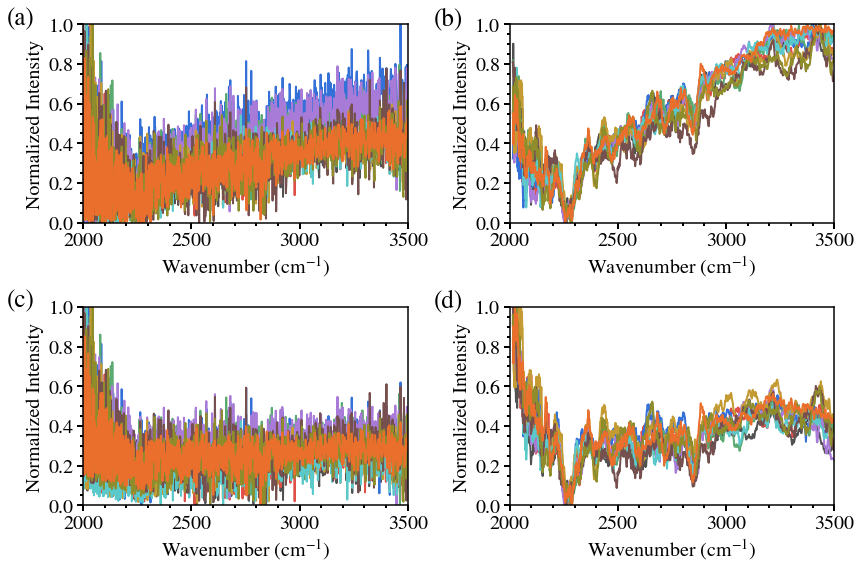

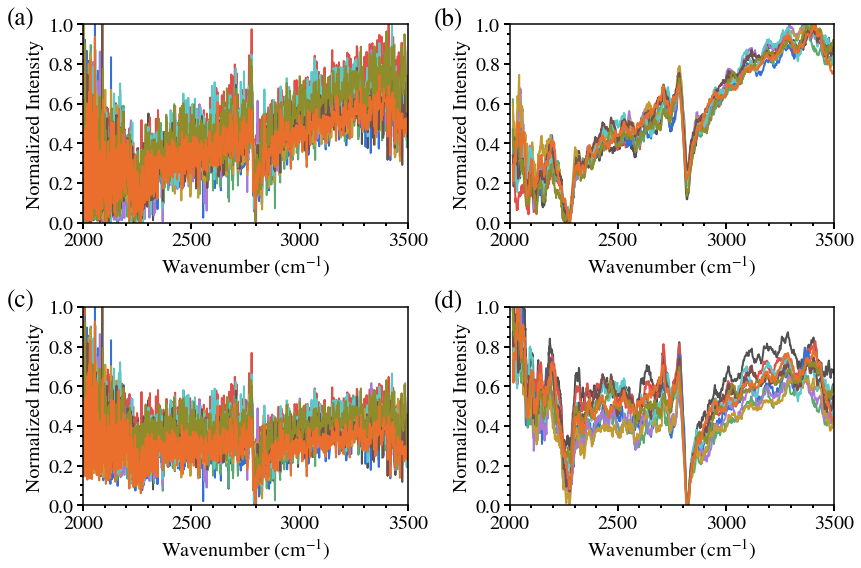

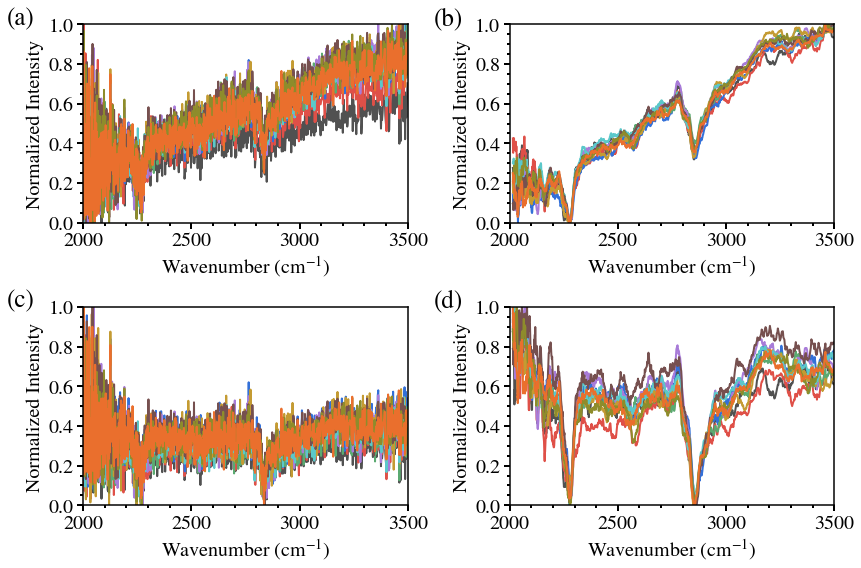

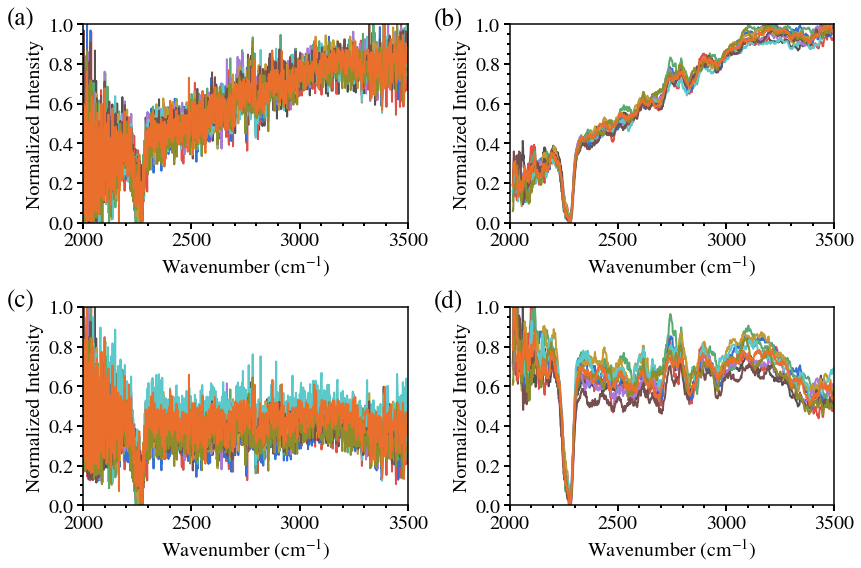

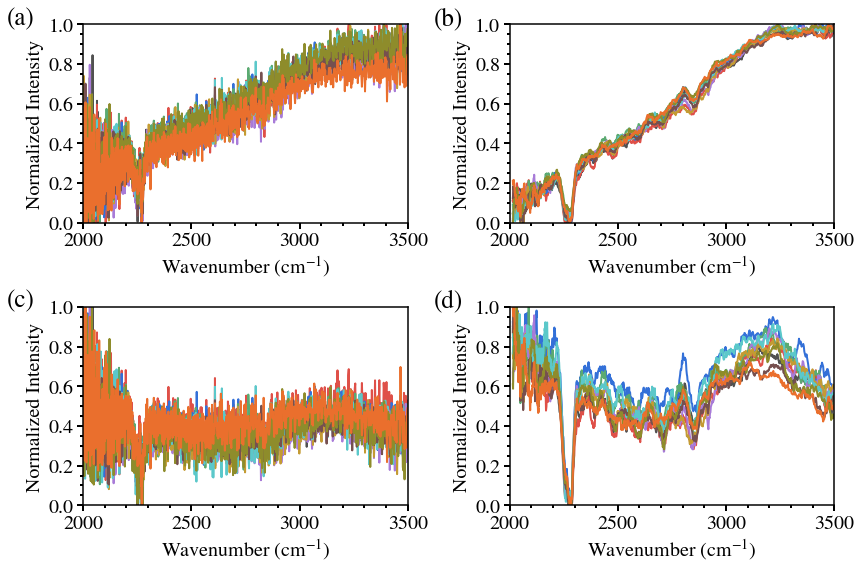

In [16]:
plastics = ['BK', 'PE', 'PP', 'PS', 'PVC']

for plastic in plastics:
    plot_spectra(x1, x2, x3, x4, y, plastic=plastic, if_save=False)

## PCA

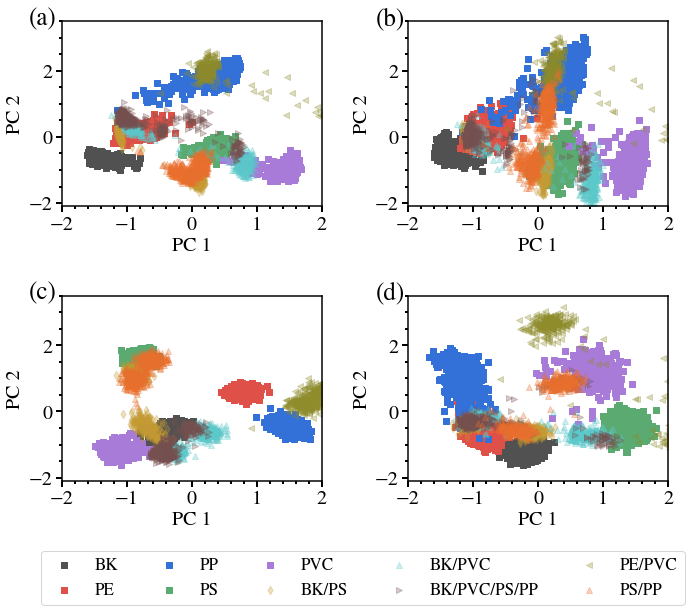

In [59]:
y_unique = np.concatenate([np.unique(y), np.unique(yu)])

# PCA decomposition
pca1 = dc.PCA(n_components=2, whiten=True, random_state=0)
x_pca1 = pca1.fit_transform(x1)
x_pca1u = pca1.fit_transform(x1u)

pca2 = dc.PCA(n_components=2, whiten=True, random_state=0)
x_pca2 = pca2.fit_transform(x2)
x_pca2u = pca1.fit_transform(x2u)

pca3 = dc.PCA(n_components=2, whiten=True, random_state=0)
x_pca3 = pca3.fit_transform(x3)
x_pca3u = pca1.fit_transform(x3u)

pca4 = dc.PCA(n_components=2, whiten=True, random_state=0)
x_pca4 = pca4.fit_transform(x4)
x_pca4u = pca1.fit_transform(x4u)

y2 = np.concatenate([y, yu])
x_pca1 = np.concatenate((x_pca1, x_pca1u), axis=0)
x_pca2 = np.concatenate((x_pca2, x_pca2u), axis=0)
x_pca3 = np.concatenate((x_pca3, x_pca3u), axis=0)
x_pca4 = np.concatenate((x_pca4, x_pca4u), axis=0)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(figsize=(10, 8), nrows=2, ncols=2)
ax = ax.ravel()

ims = []
for i, y_unique_ in enumerate(y_unique):
    idx = np.where(y2 == y_unique_)[0]
    if i == 5:
        alpha = 0.3
        marker = 'd'
    elif i == 6:
        alpha = 0.3
        marker = '^'
    elif i == 7:
        alpha = 0.3
        marker = '>'
    elif i == 8:
        alpha = 0.3
        marker = '<'
    elif i == 9:
        alpha = 0.3
        marker = '^'
    else:
        alpha = 1
        marker = 's'
    im = ax[0].scatter(x_pca1[idx[0], 0], x_pca1[idx[0], 1], c=colors[i], label=y_unique_, alpha=alpha, marker=marker)
    ims.append(im)
    ax[1].scatter(x_pca2[idx[0], 0], x_pca2[idx[0], 1], c=colors[i], label=y_unique_, alpha=alpha, marker=marker)
    ax[2].scatter(x_pca3[idx[0], 0], x_pca3[idx[0], 1], c=colors[i], label=y_unique_, alpha=alpha, marker=marker)
    ax[3].scatter(x_pca4[idx[0], 0], x_pca4[idx[0], 1], c=colors[i], label=y_unique_, alpha=alpha, marker=marker)
    
    ax[0].scatter(x_pca1[idx, 0], x_pca1[idx, 1], c=colors[i], alpha=alpha, marker=marker)
    ax[1].scatter(x_pca2[idx, 0], x_pca2[idx, 1], c=colors[i], alpha=alpha, marker=marker)
    ax[2].scatter(x_pca3[idx, 0], x_pca3[idx, 1], c=colors[i], alpha=alpha, marker=marker)
    ax[3].scatter(x_pca4[idx, 0], x_pca4[idx, 1], c=colors[i], alpha=alpha, marker=marker)

texts = ['Original', 'Smooth', 'Detrend', 'Both']
labels = ['(a)', '(b)', '(c)', '(d)']
for i, ax_ in enumerate(ax):
    bbox_props = dict(boxstyle='round', fc='None', ec='gray', lw=0.5)
    ax_.set_xlabel('PC 1', fontsize=20)
    ax_.set_ylabel('PC 2', fontsize=20)
    ax_.set_xlim([-2, 2])
    ax_.set_ylim([-2.1, 3.5])
    ax_.text(-2.5, 3.4, labels[i], fontsize=25)
    format_axis(ax_)

fig.legend(ims, y_unique, loc='lower right', bbox_to_anchor=(0.99,-0.1), ncol=int(len(y_unique)/2), bbox_transform=fig.transFigure)
plt.tight_layout()

In [63]:
pca1.explained_variance_ratio_.sum(), \
pca2.explained_variance_ratio_.sum(),\
pca3.explained_variance_ratio_.sum(),\
pca4.explained_variance_ratio_.sum()

(0.6084534882539945,
 0.9885418622735024,
 0.24833499754568572,
 0.5553484934130292)